In [ ]:
import onnxruntime as ort
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

from math import ceil
from itertools import product as product

In [ ]:
def preprocess_image(image_path):
    """
    이미지 전처리 함수:
      1. Pillow로 이미지를 로드한 후 RGB로 변환합니다.
      2. numpy 배열로 변환하여 원본 이미지의 크기를 저장합니다.
      3. 리사이즈된 이미지 배열을 float32로 변환한 후, 채널별 평균값 (104, 117, 123)을 빼줍니다.
         (원래 코드는 OpenCV로 읽은 BGR 이미지를 가정하므로, Pillow로 읽은 RGB 이미지를 BGR로 변경합니다.)
      4. (H, W, C) 배열을 (C, H, W)로 transpose하고 배치 차원(1, ...)을 추가합니다.
      
    Args:
        image_path (str): 이미지 파일 경로.
        
    Returns:
        img_final (np.ndarray): 전처리된 이미지 배열, shape=(1, C, H, W).
        scale (tuple): 원본 이미지의 크기를 나타내는 튜플, (width, height).
    """
    # 1. Pillow로 이미지 읽기 (RGB 변환)
    img = Image.open(image_path).convert('RGB')
    
    # 2. numpy 배열로 변환 (shape: [H, W, 3])
    img_np = np.array(img)
    im_height, im_width, _ = img_np.shape
    scale = (im_width, im_height)
    
    # 4. 채널 순서를 RGB -> BGR로 변경 후, float32 변환 및 채널별 평균값 빼기
    #    원래 코드는 BGR 이미지에서 (104, 117, 123)을 빼도록 되어 있습니다.
    img_np = img_np[..., ::-1]  # RGB -> BGR 변환
    img_np = img_np.astype(np.float32)
    img_np -= np.array([104, 117, 123], dtype=np.float32)
    
    # 5. (H, W, C) -> (C, H, W)로 transpose하고 배치 차원 추가
    img_transposed = np.transpose(img_np, (2, 0, 1))
    img_final = np.expand_dims(img_transposed, axis=0)
    
    return img_final, scale

def run_inference(input_tensor, model_path):
    """
    ONNX 모델을 로드하여 이미지 입력에 대해 추론을 수행하는 함수입니다.
    - image_path: 추론에 사용할 이미지 파일 경로
    - model_path: ONNX 모델 파일 경로
    
    리턴: 모델의 추론 결과 (출력 리스트)
    """
    # ONNX Runtime 세션 생성
    session = ort.InferenceSession(model_path)
    
    # 모델 입력 이름 얻기
    input_name = session.get_inputs()[0].name
    print(f"모델 입력 이름: {input_name}")
    
    # 추론 실행
    outputs = session.run(None, {input_name: input_tensor})
    
    return outputs

In [92]:
class PriorBox(object):
    def __init__(self, cfg, image_size=None, phase='train'):
        super(PriorBox, self).__init__()
        self.min_sizes = cfg['min_sizes']
        self.steps = cfg['steps']
        self.clip = cfg['clip']
        self.image_size = image_size
        self.feature_maps = [[ceil(self.image_size[0]/step), ceil(self.image_size[1]/step)] for step in self.steps]
        self.name = "s"

    def forward(self):
        anchors = []
        for k, f in enumerate(self.feature_maps):
            min_sizes = self.min_sizes[k]
            for i, j in product(range(f[0]), range(f[1])):
                for min_size in min_sizes:
                    s_kx = min_size / self.image_size[1]
                    s_ky = min_size / self.image_size[0]
                    dense_cx = [x * self.steps[k] / self.image_size[1] for x in [j + 0.5]]
                    dense_cy = [y * self.steps[k] / self.image_size[0] for y in [i + 0.5]]
                    for cy, cx in product(dense_cy, dense_cx):
                        anchors += [cx, cy, s_kx, s_ky]

        # back to numpy
        output = np.array(anchors).reshape(-1, 4)
        if self.clip:
            output = np.clip(output, 0, 1)
        return output

In [93]:
def decode(loc, priors, variances):
    """
    학습 시 offset regression을 위해 인코딩된 박스 정보를 원래 좌표로 복원합니다.
    
    Args:
        loc (np.ndarray): 위치 예측 배열, shape=(num_priors, 4)
        priors (np.ndarray): center-offset 형식의 prior boxes, shape=(num_priors, 4)
        variances (list[float]): prior box에 사용한 variance 값, 예: [0.1, 0.2]
        
    Returns:
        np.ndarray: 복원된 bounding box 좌표, 각 행이 [xmin, ymin, xmax, ymax] 형태.
    """
    # 중심 좌표 (cx, cy) 복원: priors의 중심에 offset을 더함
    center = priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:]
    
    # width, height 복원: prior의 크기에 exp(offset)을 곱함
    size = priors[:, 2:] * np.exp(loc[:, 2:] * variances[1])
    
    # 좌상단, 우하단 좌표 계산: center와 size를 이용해 [xmin, ymin, xmax, ymax] 계산
    boxes = np.concatenate((center - size / 2, center + size / 2), axis=1)
    
    return boxes

def decode_landm(pre, priors, variances):
    """
    학습 시 인코딩된 landmark 정보를 원래 좌표로 복원합니다.
    
    Args:
        pre (np.ndarray): landmark 예측 배열, shape=(num_priors, 10)
        priors (np.ndarray): center-offset 형식의 prior boxes, shape=(num_priors, 4)
        variances (list[float]): prior box에 사용한 variance 값, 예: [0.1, 0.2]
        
    Returns:
        np.ndarray: 복원된 landmark 좌표, 각 행이 10개의 좌표값을 포함.
    """
    # 5개의 landmark 좌표 (x, y) 쌍에 대해 각각 복원 수행
    landm1 = priors[:, :2] + pre[:, :2]   * variances[0] * priors[:, 2:]
    landm2 = priors[:, :2] + pre[:, 2:4]  * variances[0] * priors[:, 2:]
    landm3 = priors[:, :2] + pre[:, 4:6]  * variances[0] * priors[:, 2:]
    landm4 = priors[:, :2] + pre[:, 6:8]  * variances[0] * priors[:, 2:]
    landm5 = priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:]
    
    # 5쌍의 landmark를 하나의 배열로 결합 (각 행은 10개 좌표)
    landms = np.concatenate((landm1, landm2, landm3, landm4, landm5), axis=1)
    
    return landms

def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [94]:
def post_process(output, cfg, scale,
                 confidence_threshold=0.5, top_k=5000, nms_threshold=0.3, keep_top_k=750):
    """
    ONNX 모델 출력에 따른 후처리 함수.
    
    Args:
        output (list): ONNX 모델의 예측 출력. (loc, conf, landms) 구성. 
            loc (np.ndarray): ONNX 모델의 위치 예측 출력, shape=(1, num_priors, 4)
            conf (np.ndarray): ONNX 모델의 클래스 확률 출력, shape=(1, num_priors, num_classes)
            landms (np.ndarray): ONNX 모델의 landmark 예측 출력, shape=(1, num_priors, 10)
        cfg (dict): 모델 구성 정보 (예: 'variance' 등)
        scale (np.ndarray): 원본 이미지 사이즈 (width, height). 예: (640, 640)
        confidence_threshold (float): 후보 box의 최소 신뢰도 임계값
        top_k (int): NMS 전 후보 상위 선택 개수
        nms_threshold (float): NMS 임계값
        keep_top_k (int): NMS 후 최종 선택할 후보 개수
    
    Returns:
        dets (np.ndarray): 최종 detection 결과 배열. 각 row는
                           [x1, y1, x2, y2, score, ldm1, ldm2, ..., ldm10] 형태.
    """
    resize = 1
    loc, conf, landms = output
    im_width, im_height = scale
    
    # 1. PriorBox 생성 (numpy 기반 구현이어야 함)
    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()  # priors: numpy 배열, shape=(num_priors, 4)
    
    # 2. bounding box 복원 (squeeze: 배치 차원 제거)
    boxes = decode(np.squeeze(loc, axis=0), priors, cfg['variance'])
    scale_bbox = np.array([im_width, im_height] * 2, dtype=np.float32)
    boxes = boxes * scale_bbox  / resize

    # 3. 클래스 확률 (두 번째 클래스, 즉 positive class의 확률)
    scores = np.squeeze(conf, axis=0)[:, 1]

    # 4. landmark 복원
    landms = decode_landm(np.squeeze(landms, axis=0), priors, cfg['variance'])
    # landmark 좌표 스케일: 네트워크 입력 크기를 기준으로 5쌍의 (x, y)
    scale_ld = np.array([im_width, im_height] * 5, dtype=np.float32)
    landms = landms * scale_ld  / resize

    # 5. 신뢰도 임계값보다 낮은 후보 제거
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # 6. NMS 전 상위 top_k 후보 선택
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # 7. NMS 수행 (py_cpu_nms: numpy 기반 NMS 함수)
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    dets = dets[keep, :]
    landms = landms[keep]

    # 8. NMS 후 최종 상위 keep_top_k 후보 선택
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    # 9. bounding box와 landmark 결과 결합
    dets = np.concatenate((dets, landms), axis=1)
    
    return dets

In [95]:
def show_image(image_path, dets, vis_thres=0.6): 
    img = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    for b in dets:
        if b[4] < vis_thres:
            continue
        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        draw.rectangle([(b[0], b[1]), (b[2], b[3])], outline="red", width=3)
        cx = b[0] + 3
        cy = b[1]
        
        try:
            font = ImageFont.truetype("arial.ttf", 30)
        except IOError:
            font = ImageFont.load_default()
        draw.text((cx, cy), text, fill="white", font=font)

        # landms
        draw.ellipse(circle_point(b[5], b[6], 2), fill=(0, 255, 0))
        draw.ellipse(circle_point(b[7], b[8], 2), fill=(255, 0, 0))
        draw.ellipse(circle_point(b[9], b[10], 2), fill=(255, 0, 0))
        draw.ellipse(circle_point(b[11], b[12], 2), fill=(0, 255, 0))
        draw.ellipse(circle_point(b[13], b[14], 2), fill=(255, 0, 0))
        
    # save image
    plt.imshow(img)
    plt.show()
    
def circle_point(x, y, r):
    return (x - r, y - r, x + r, y + r)

In [96]:
cfg_re50 = {
    'name': 'Resnet50',
    'min_sizes': [[16, 32], [64, 128], [256, 512]],
    'steps': [8, 16, 32],
    'variance': [0.1, 0.2],
    'clip': False,
    'loc_weight': 2.0,
    'gpu_train': True,
    'batch_size': 24,
    'ngpu': 4,
    'epoch': 100,
    'decay1': 70,
    'decay2': 90,
    'image_size': 840,
    'pretrain': True,
    'return_layers': {'layer2': 1, 'layer3': 2, 'layer4': 3},
    'in_channel': 256,
    'out_channel': 256
}

모델 입력 이름: input0


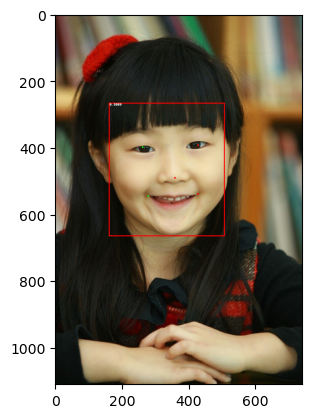

In [97]:
# 사용 예시:
image_path = 'test3.jpg'   # 추론에 사용할 이미지 파일 경로
model_path = 'FaceDetector.onnx' # ONNX 모델 파일 경로

input_tensor, scale = preprocess_image(image_path)
# 추론 수행 및 결과 출력
results = run_inference(input_tensor, model_path)
dets = post_process(results, cfg_re50, scale)
show_image(image_path, dets)